In [2]:
import os, re
import pandas as pd
import numpy as np
from pyfaidx import Fasta 

import importlib
import _config
importlib.reload(_config)
from _config import DATA_DIR, OUT_PLACE 

#use your data directory to locate your data files
NOREPEATS_DATA_DIR = os.path.join(DATA_DIR, "no_repeats")
HYPER_DATA_DIR = os.path.join(DATA_DIR, "encode")

OUT_DIR = os.path.join(OUT_PLACE,"eccdna")
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)
    
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
import argparse
import seaborn as sns
%matplotlib inline

/cluster/shz24/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cluster/shz24/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/cluster/shz24/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/cluster/shz24/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cluster/shz24/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/cluster/shz24/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 47

In [3]:
refseq = pd.read_csv("/cluster/bh0085/genomes/mm10_refseq.csv", delimiter = "\t")
gene_bounds =pd.concat([refseq.groupby("name2").cdsStart.min().rename("start"),
                    refseq.groupby("name2").cdsEnd.max().rename("end"),
                   refseq.groupby("name2").chrom.first().rename("chrom"),
                   refseq.groupby("name2").strand.first().rename("strand")], axis = 1)
gene_bounds = gene_bounds.loc[gene_bounds.end-gene_bounds.start < 1000000] #filters out genes that are larger than 1 mil
#gene bounds = index: name2, columns: start, end, chrom, strand
#region defined as (start-10000, end+10,000)
#create 2 columns for hypersensitivity in ES and MN cells

# MN_path = os.path.join(HYPER_DATA_DIR, "MN_ENCFF840MRT.bed")
# MN_loci = pd.read_csv(MN_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

ES_path = os.path.join(HYPER_DATA_DIR, "ES_ENCFF319IPQ.bed")
ES_loci = pd.read_csv(ES_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

In [4]:
MN_new_path = os.path.join(HYPER_DATA_DIR, "ENCFF979URU.bed")
MN_new_loci = pd.read_csv(MN_new_path, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")

143271
129748
85809


In [5]:
gene_bounds["MN_hyper_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)
gene_bounds["ES_hyper_cov"] = pd.Series([0 for x in range(len(gene_bounds.index))], index=gene_bounds.index)
gene_bounds["start_region"] = gene_bounds.start-10000
gene_bounds["end_region"] = gene_bounds.end+10000
# trick - only look in the chromosome you're currently (MN_chrom1)

In [20]:
chrom1_test = gene_bounds.loc[gene_bounds.chrom=='chr1']

In [6]:
ES_chrom1 = ES_loci.loc[ES_loci.chrom=='chr1']
MN_chrom1_new = MN_new_loci.loc[MN_new_loci.chrom=='chr1']

In [8]:
chrom1_test_copy = chrom1_test

In [89]:
ES_chrom2 = ES_loci.loc[(ES_loci.chrom=="chr2")]
MN_chrom2 = MN_new_loci.loc[(MN_new_loci.chrom=='chr2')]

In [97]:
ES_chrom3 = ES_loci.loc[(ES_loci.chrom=="chr3")]
MN_chrom3 = MN_new_loci.loc[(MN_new_loci.chrom=='chr3')]

In [ ]:
def hyper_coverage(loci, celltype, cellfile):
    for gene in loci.itertuples():
        for h in celltype.itertuples():
            start = max(gene.start_region, h.start)
            end = min(gene.end_region, h.end)
            length = max(0, end-start)
            loci.at[gene.Index, celltype + "_hyper_cov"] = loci.at[gene.Index, celltype + "_hyper_cov"]+length

In [9]:
for gene in chrom1_test_copy.itertuples():
    for h in ES_chrom1.itertuples():
        start = max(gene.start_region, h.start)
        end = min(gene.end_region, h.end)
        length = max(0, end-start)
        chrom1_test_copy.at[gene.Index, "ES_hyper_cov"] = chrom1_test_copy.at[gene.Index, "ES_hyper_cov"]+length

In [21]:
for gene in chrom1_test_copy.itertuples():
    for h in MN_chrom1_new.itertuples():
        start = max(gene.start_region, h.start)
        end = min(gene.end_region, h.end)
        length = max(0, end-start)
        chrom1_test_copy.at[gene.Index, "MN_hyper_cov"] = chrom1_test_copy.at[gene.Index, "MN_hyper_cov"]+length

In [88]:
chrom2_test = gene_bounds.loc[(gene_bounds.chrom=='chr2')]

In [98]:
chrom3_test = gene_bounds.loc[(gene_bounds.chrom=="chr3")]

In [90]:
#testing chrom 2
for gene in chrom2_test.itertuples():
    for h in MN_chrom2.itertuples():
        start = max(gene.start_region, h.start)
        end = min(gene.end_region, h.end)
        length = max(0, end-start)
        chrom2_test.at[gene.Index, "MN_hyper_cov"] = chrom2_test.at[gene.Index, "MN_hyper_cov"]+length

In [91]:
for gene in chrom2_test.itertuples():
    for h in ES_chrom2.itertuples():
        start = max(gene.start_region, h.start)
        end = min(gene.end_region, h.end)
        length = max(0, end-start)
        chrom2_test.at[gene.Index, "ES_hyper_cov"] = chrom2_test.at[gene.Index, "ES_hyper_cov"]+length

In [99]:
#testing chrom 3
for gene in chrom3_test.itertuples():
    for h in MN_chrom3.itertuples():
        start = max(gene.start_region, h.start)
        end = min(gene.end_region, h.end)
        length = max(0, end-start)
        chrom3_test.at[gene.Index, "MN_hyper_cov"] = chrom3_test.at[gene.Index, "MN_hyper_cov"]+length

In [100]:
for gene in chrom3_test.itertuples():
    for h in ES_chrom3.itertuples():
        start = max(gene.start_region, h.start)
        end = min(gene.end_region, h.end)
        length = max(0, end-start)
        chrom3_test.at[gene.Index, "ES_hyper_cov"] = chrom3_test.at[gene.Index, "ES_hyper_cov"]+length

In [10]:
chrom1_test_copy.ES_hyper_cov = chrom1_test_copy.ES_hyper_cov/100

/cluster/shz24/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [22]:
chrom1_test_copy.MN_hyper_cov = chrom1_test_copy.MN_hyper_cov/100

/cluster/shz24/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [92]:
chrom2_test.ES_hyper_cov = chrom2_test.ES_hyper_cov/100
chrom2_test.MN_hyper_cov = chrom2_test.MN_hyper_cov/100

/cluster/shz24/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [101]:
chrom3_test.ES_hyper_cov = chrom3_test.ES_hyper_cov/100
chrom3_test.MN_hyper_cov = chrom3_test.MN_hyper_cov/100

/cluster/shz24/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [17]:
def gene_counts(genes, celltype, threshold):
    return len(genes.loc[genes[celltype] > threshold])

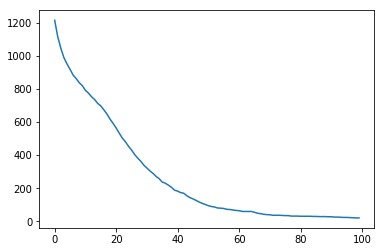

In [23]:
xindex = np.arange(100)
lst = np.zeros(100)
for i in xindex:
    lst[i] = gene_counts(chrom1_test_copy, "MN_hyper_cov", i)
plt.plot(xindex, lst)

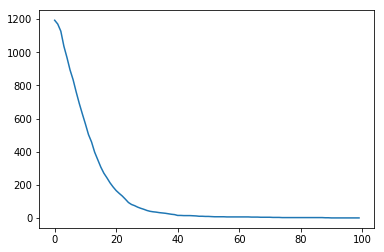

In [24]:
xindex = np.arange(100)
lst = np.zeros(100)
for i in xindex:
    lst[i] = gene_counts(chrom1_test_copy, "ES_hyper_cov", i)
plt.plot(xindex, lst)

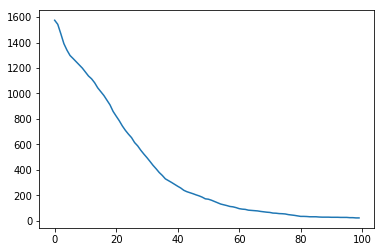

In [93]:
xindex = np.arange(100)
lst = np.zeros(100)
for i in xindex:
    lst[i] = gene_counts(chrom2_test, "MN_hyper_cov", i)
plt.plot(xindex, lst)

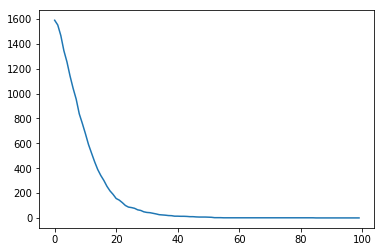

In [94]:
xindex = np.arange(100)
lst = np.zeros(100)
for i in xindex:
    lst[i] = gene_counts(chrom2_test, "ES_hyper_cov", i)
plt.plot(xindex, lst)

In [54]:
def gene_on_off(genes, celltype, threshold):
    return genes[celltype].apply(lambda x: 1 if x > threshold else 0)

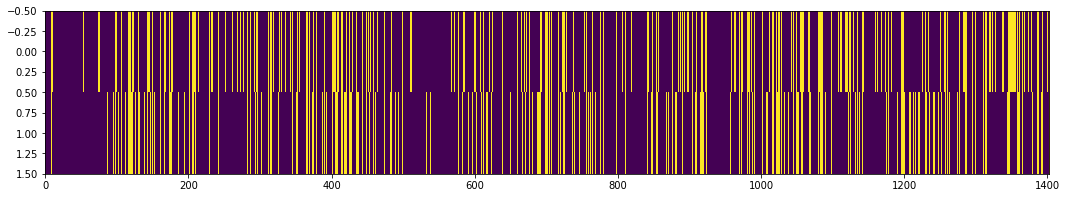

In [69]:
#using 25 as threshold for MN, 15 as threshold for ES
img = np.array([chrom1_test_copy.MN_hyper_cov.apply(lambda x: 1 if x > 30 else 0)
                , chrom1_test_copy.ES_hyper_cov.apply(lambda x: 1 if x > 15 else 0)])
f = plt.figure()
f.set_size_inches(18, 3)
im = plt.imshow(img, aspect="auto")

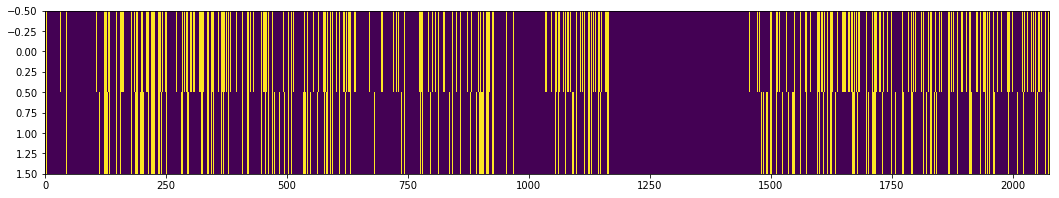

In [95]:
#using 25 as threshold for MN, 15 as threshold for ES
img = np.array([chrom2_test.MN_hyper_cov.apply(lambda x: 1 if x > 30 else 0)
                , chrom2_test.ES_hyper_cov.apply(lambda x: 1 if x > 15 else 0)])
f = plt.figure()
f.set_size_inches(18, 3)
im = plt.imshow(img, aspect="auto")

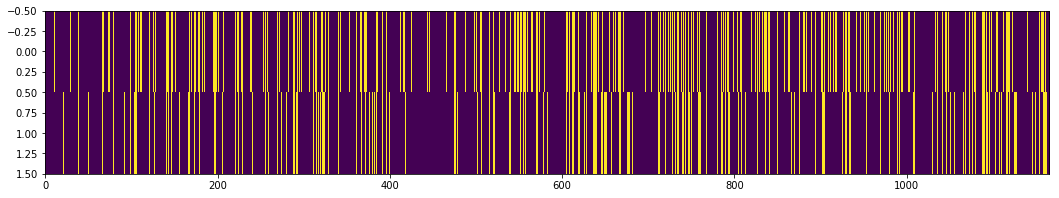

In [106]:
#using 25 as threshold for MN, 15 as threshold for ES
img = np.array([chrom3_test.MN_hyper_cov.apply(lambda x: 1 if x > 30 else 0)
                , chrom3_test.ES_hyper_cov.apply(lambda x: 1 if x > 15 else 0)])
f = plt.figure()
f.set_size_inches(18, 3)
im = plt.imshow(img, aspect="auto")

In [108]:
df = pd.concat([chrom1_test_copy, chrom2_test, chrom3_test])
df.to_csv("chrom_hypersensitivity_1-3.csv", sep='\t')

In [37]:
chrom1_MN_topgenes = chrom1_test_copy.sort_values(["MN_hyper_cov"], ascending =False)
MN_topgenes = chrom1_MN_topgenes.head(800)

In [38]:
chrom1_ES_topgenes = chrom1_test_copy.sort_values(["ES_hyper_cov"], ascending=False)
ES_topgenes = chrom1_ES_topgenes.head(800)

In [39]:
MN_topgenes.reset_index(inplace=True)
ES_topgenes.reset_index(inplace=True)

In [96]:
len(ES_topgenes.merge(MN_topgenes, indicator=True, how='inner', on='name2'))
# 37 out of the 100 top genes are the same for both cell types - 161 genes that are not the same in the 200 count set

636